In [1]:
! head -1 ../data/bike-dataset/hour.csv

In [2]:
!sed 1d ../data/bike-dataset/hour.csv > ../data/bike-dataset/hour_noheader.csv

In [3]:
import numpy as np
hour_path = '../data/bike-dataset/hour_noheader.csv'

In [4]:
raw_data = sc.textFile(hour_path)

In [5]:
num_data = raw_data.count()
records =raw_data.map(lambda x: x.split(','))

In [6]:
first = records.first()
print 'the first data:'
print first
print 'the data num in this dataset: %d'%num_data

the first data:
[u'1', u'2011-01-01', u'1', u'0', u'1', u'0', u'0', u'6', u'0', u'1', u'0.24', u'0.2879', u'0.81', u'0', u'3', u'13', u'16']
the data num in this dataset: 17379


In [7]:
records.cache()

PythonRDD[4] at RDD at PythonRDD.scala:43

In [8]:
def get_mapping(rdd, idx):
    return rdd.map(lambda fields: fields[idx]).distinct().zipWithIndex().collectAsMap()

In [9]:
print "Mapping of first categorical feature column %s "%get_mapping(records,2)

Mapping of first categorical feature column {u'1': 0, u'3': 1, u'2': 2, u'4': 3} 


In [10]:
mappings = [get_mapping(records, i) for i in range(2,10)]
cat_len = sum(map(len, mappings))
num_len = len(records.first()[11:15])
map(len,mappings)
total_len = num_len+cat_len

In [11]:
print 'Feature vector length for categorical features %d'%cat_len
print 'Feature vector length for numerical features %d'%num_len
print 'Total feature vector length: %d' % total_len

Feature vector length for categorical features 57
Feature vector length for numerical features 4
Total feature vector length: 61


In [12]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np
def extract_features(record):
    cat_vec = np.zeros(cat_len)
    step = 0
    for i,field in enumerate(record[2:9]):
        m = mappings[i]
        idx = m[field]
        cat_vec[idx+step] = 1
        step = step+len(m)
    num_vec = np.array([float(field) for field in record[10:14]])
    return np.concatenate((cat_vec, num_vec))

In [13]:
def extract_label(record):
    return float(record[-1])

In [14]:
data = records.map(lambda r: LabeledPoint(extract_label(r),extract_features(r)))

In [15]:
first_point = data.first()
print 'raw data: '+str(first[2:])
print 'label: ' + str(first_point.label)
print 'feature vector: \n' + str(first_point.features)
print 'feature vector length:' + str(len(first_point.features))

raw data: [u'1', u'0', u'1', u'0', u'0', u'6', u'0', u'1', u'0.24', u'0.2879', u'0.81', u'0', u'3', u'13', u'16']
label: 16.0
feature vector: 
[1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0]
feature vector length:61


In [16]:
# decsion tree can work on raw features, it is not required to convert category features to a binary vector
def extract_features_dt(record):
    return np.array(map(float, record[2:14]))

In [20]:
data_dt = records.map(lambda r: LabeledPoint(extract_label(r), extract_features_dt(r)))

In [21]:
first_point_dt = data_dt.first()

In [22]:
print 'Decision Tree vector: '+str(first_point_dt.features)
print 'Decision Tree vector: '+str(len(first_point_dt.features))

Decision Tree vector: [1.0,0.0,1.0,0.0,0.0,6.0,0.0,1.0,0.24,0.2879,0.81,0.0]
Decision Tree vector: 12


In [46]:
# Training and using regression models
from pyspark.mllib.regression import LinearRegressionWithSGD
from pyspark.mllib.tree import DecisionTree
# help(LinearRegressionWithSGD.train)
# help(DecisionTree.trainRegressor)
linear_model = LinearRegressionWithSGD.train(data, iterations=10, step=0.1)

In [47]:
true_vs_predicted = data.map(lambda p:(p.label,linear_model.predict(p.features)))

In [48]:
print 'Linear Model predictions: '+ str(true_vs_predicted.take(5))

Linear Model predictions: [(16.0, 117.89250386724844), (40.0, 116.22496123192109), (32.0, 116.02369145779232), (13.0, 115.67088016754431), (1.0, 115.56315650834316)]


In [49]:
dt_model = DecisionTree.trainRegressor(data_dt,{})
preds = dt_model.predict(data_dt.map(lambda p: p.features))
actual = data.map(lambda p:p.label)
true_vs_predicted_dt = actual.zip(preds)
print 'Decision Tree predictions: '+str(true_vs_predicted_dt.take(5))
print 'Decision Tree depth: ' + str(dt_model.depth())
print 'Decision Tree number of nodes: '+str(dt_model.numNodes())

Decision Tree predictions: [(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945), (13.0, 14.284023668639053), (1.0, 14.284023668639053)]
Decision Tree depth: 5
Decision Tree number of nodes: 63


In [50]:
# Evaluating the performance of Regression models

In [51]:
def squared_error(actual, pred):
    return (pred-actual)**2

In [52]:
def abs_error(actual, pred):
    return np.abs(pred-actual)

In [53]:
def squared_log_error(pred, actual):
    return (np.log(pred+1)-np.log(actual+1))**2

In [54]:
# The R-squared coefficient
mse = true_vs_predicted.map(lambda (t, p): squared_error(t, p)).mean()
mae = true_vs_predicted.map(lambda (t, p): abs_error(t, p)).mean()
rmsle = np.sqrt(true_vs_predicted.map(lambda (t, p): squared_log_error(t, p)).mean())
print "Linear Model - Mean Squared Error: %2.4f" % mse
print "Linear Model - Mean Absolute Error: %2.4f" % mae
print "Linear Model - Root Mean Squared Log Error: %2.4f" % rmsle

Linear Model - Mean Squared Error: 30679.4539
Linear Model - Mean Absolute Error: 130.6429
Linear Model - Root Mean Squared Log Error: 1.4653


In [55]:
mse_dt = true_vs_predicted_dt.map(lambda (t, p): squared_error(t, p)).mean()
mae_dt = true_vs_predicted_dt.map(lambda (t, p): abs_error(t, p)).mean()
rmsle_dt = np.sqrt(true_vs_predicted_dt.map(lambda (t, p): squared_log_error(t, p)).mean())
print "Decision Tree - Mean Squared Error: %2.4f" % mse_dt
print "Decision Tree - Mean Absolute Error: %2.4f" % mae_dt
print "Decision Tree - Root Mean Squared Log Error: %2.4f" %rmsle_dt


Decision Tree - Mean Squared Error: 11560.7978
Decision Tree - Mean Absolute Error: 71.0969
Decision Tree - Root Mean Squared Log Error: 0.6259


In [56]:
# Imporving model performance and tuning parameters

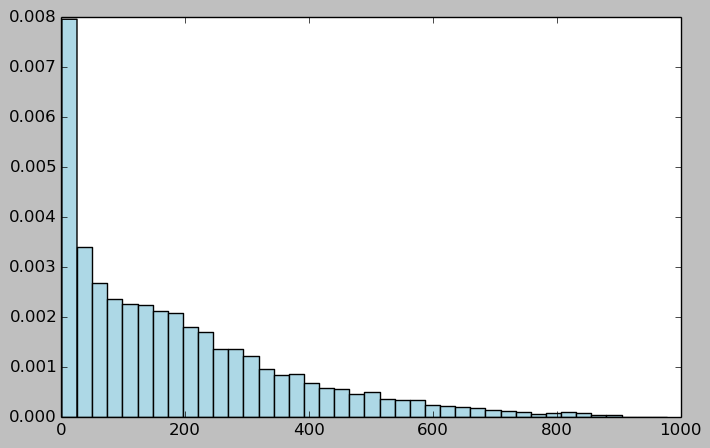

In [57]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  
targets = records.map(lambda r: float(r[-1])).collect()
plt.hist(targets, bins=40, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 5)

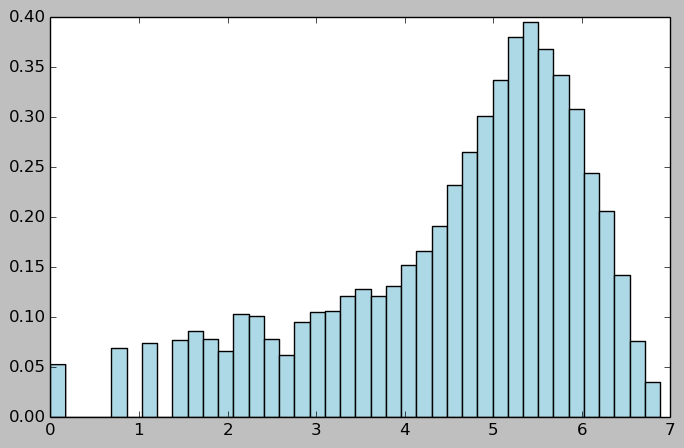

In [58]:
log_targets = records.map(lambda r : np.log(float(r[-1]))).collect()
plt.hist(log_tartgets, bins = 40, color ='lightblue', normed =True)
fig = plt.gcf()
fig.set_size_inches(8,5)

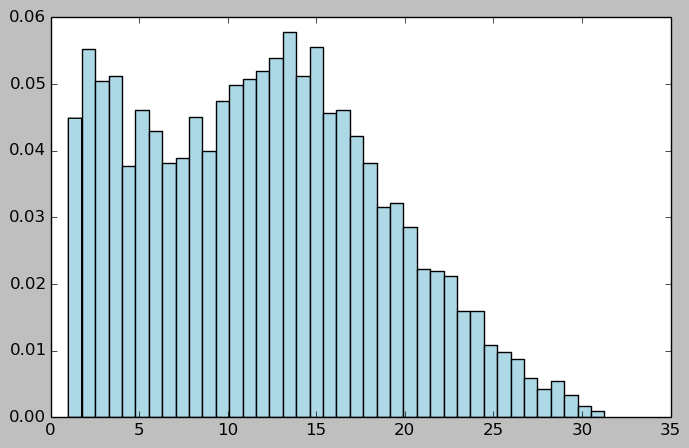

In [59]:
sqrt_targets = records.map(lambda r: np.sqrt(float(r[-1]))).collect()
plt.hist(sqrt_targets, bins=40, color='lightblue', normed=True)
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(8, 5)

In [60]:
data_log = data.map(lambda lp: LabeledPoint(np.log(lp.label),lp.features))
model_log = LinearRegressionWithSGD.train(data_log, iterations=10, step=0.1)

In [61]:
true_vs_predicted_log = data_log.map(lambda p: (np.exp(p.label),np.exp(model_log.predict(p.features))))

In [62]:
mse_log = true_vs_predicted_log.map(lambda (t, p): squared_error(t,p)).mean()
mae_log = true_vs_predicted_log.map(lambda (t, p): abs_error(t, p)).mean()
rmsle_log = np.sqrt(true_vs_predicted_log.map(lambda (t, p): squared_log_error(t, p)).mean())
print "Mean Squared Error: %2.4f" % mse_log
print "Mean Absolue Error: %2.4f" % mae_log
print "Root Mean Squared Log Error: %2.4f" % rmsle_log
print "Non log-transformed predictions:\n" + str(true_vs_predicted.take(3))
print "Log-transformed predictions:\n" + str(true_vs_predicted_log.take(3))


Mean Squared Error: 50685.5559
Mean Absolue Error: 155.2955
Root Mean Squared Log Error: 1.5411
Non log-transformed predictions:
[(16.0, 117.89250386724844), (40.0, 116.22496123192109), (32.0, 116.02369145779232)]
Log-transformed predictions:
[(15.999999999999998, 28.080291845456212), (40.0, 26.959480191001763), (32.0, 26.654725629457996)]


In [55]:
data_dt_log = data_dt.map(lambda lp:LabeledPoint(np.log(lp.label), lp.features))
dt_model_log = DecisionTree.trainRegressor(data_dt_log,{})
preds_log = dt_model_log.predict(data_dt_log.map(lambda p:p.features))
actual_log = data_dt_log.map(lambda p: p.label)
true_vs_predicted_dt_log = actual_log.zip(preds_log).map(lambda (t,p): (np.exp(t), np.exp(p)))
mse_log_dt = true_vs_predicted_dt_log.map(lambda (t, p): squared_error(t, p)).mean()
mae_log_dt = true_vs_predicted_dt_log.map(lambda (t, p): abs_error(t,p)).mean()
rmsle_log_dt = np.sqrt(true_vs_predicted_dt_log.map(lambda (t, p):
squared_log_error(t, p)).mean())
print "Mean Squared Error: %2.4f" % mse_log_dt
print "Mean Absolue Error: %2.4f" % mae_log_dt
print "Root Mean Squared Log Error: %2.4f" % rmsle_log_dt
print "Non log-transformed predictions:\n" + str(true_vs_predicted_dt.take(3))
print "Log-transformed predictions:\n" +str(true_vs_predicted_dt_log.take(3))

Mean Squared Error: 14781.5760
Mean Absolue Error: 76.4131
Root Mean Squared Log Error: 0.6406
Non log-transformed predictions:
[(16.0, 54.913223140495866), (40.0, 54.913223140495866), (32.0, 53.171052631578945)]
Log-transformed predictions:
[(15.999999999999998, 37.530779787154508), (40.0, 37.530779787154508), (32.0, 7.2797070993907127)]


#Tuning model parameters

##Create training and testing sets to evaluate parameters

In [64]:
data_with_idx = data.zipWithIndex().map(lambda (k,v):(v,k))
train_test_data_split = data.randomSplit([0.8,0.2],123)
train1 = train_test_data_split[0]
test1=train_test_data_split[1]
test = data_with_idx.sample(False, 0.2, 42)
train = data_with_idx.subtractByKey(test)

In [65]:
print test.count()
print train.count()
print test1.count()
print train1.count()

3536
13843
3519
13860


In [66]:
train_data = train.map(lambda (idx,p):p)
test_data = test.map(lambda (idx,p) : p)
train_size = train_data.count()
test_size = test_data.count()
print "Training data size : %d " % train_size
print "Test data size: %d" % test_size
print "Total data size: %d"%num_data
print "Train + Test size: %d" % (train_size+test_size)

Training data size : 13843 
Test data size: 3536
Total data size: 17379
Train + Test size: 17379


In [67]:
data_with_idx_dt = data_dt.zipWithIndex().map(lambda (k,v):(v,k))
test_dt = data_with_idx_dt.sample(False, 0.2, 42)
train_dt = data_with_idx_dt.subtractByKey(test_dt)
train_data_dt = train_dt.map(lambda (idx,p):p)
test_data_dt = test_dt.map(lambda (idx, p):p)
train_test_data_dt_split = data.randomSplit([0.8,0.2],123)
train1_dt = train_test_data_dt_split[0]
test1_dt=train_test_data_split[1]

In [68]:
def evaluate(train, test, iterations, step, regParam, regType, intercept):
    model = LinearRegressionWithSGD.train(train, iterations, step, regParam=regParam, regType=regType,intercept=intercept)
    tp = test.map(lambda p:(p.label, model.predict(p.features)))
    rmsle = np.sqrt(tp.map(lambda (t,p):squared_log_error(t,p)).mean())
    return rmsle

In [73]:
params = [1, 5, 10, 20, 50, 100]
# metrics = [evaluate(train_data, test_data,param, 0.01, 0.0,'l2',False) for param in params]
metrics = [evaluate(train1, test1,param, 0.01, 0.0,'l2',False) for param in params]
for i in range(len(params)):
    print 'the rmsle: %f when iterations :%d'%(metrics[i],params[i])


the rmsle: 2.927743 when iterations :1
the rmsle: 2.068696 when iterations :5
the rmsle: 1.792306 when iterations :10
the rmsle: 1.582446 when iterations :20
the rmsle: 1.413309 when iterations :50
the rmsle: 1.362821 when iterations :100


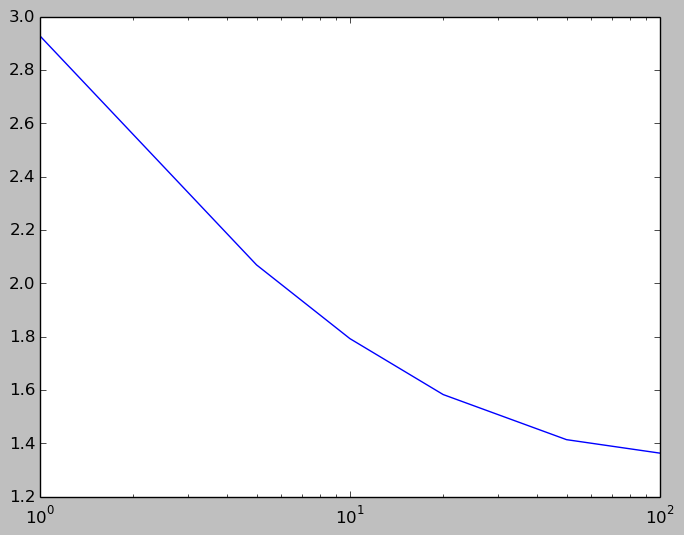

In [71]:
plt.plot(params, metrics)
fig = plt.gcf()
plt.xscale('log')

In [81]:
params = [0.01, 0.025, 0.05, 0.1, 0.5]
metrics = [evaluate(train_data, test_data, 10,param,0.0,'l2',False) for param in params]
for i in range(len(params)):
    print 'the rmsle: %f when step :%f'%(metrics[i],params[i])

the rmsle: 1.790424 when step :0.010000
the rmsle: 1.424106 when step :0.025000
the rmsle: 1.384013 when step :0.050000
the rmsle: 1.456006 when step :0.100000
the rmsle: 1.420514 when step :0.500000


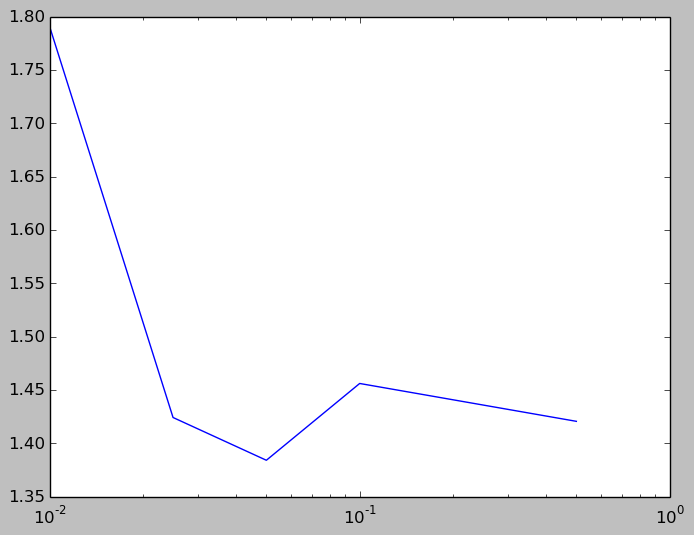

In [82]:
plt.plot(params,metrics)
fig = plt.gcf()
plt.xscale('log')

the rmsle: 1.456006 when regParam :0.000000
the rmsle: 1.455391 when regParam :0.010000
the rmsle: 1.449963 when regParam :0.100000
the rmsle: 1.406437 when regParam :1.000000
the rmsle: 1.391879 when regParam :5.000000
the rmsle: 1.537280 when regParam :10.000000
the rmsle: 1.844356 when regParam :20.000000


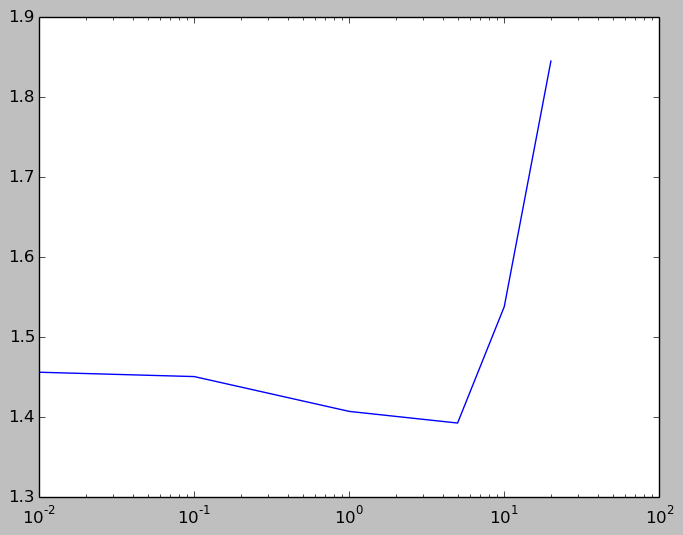

In [85]:
params = [0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
metrics = [evaluate(train_data, test_data, 10, 0.1, param, 'l2', False) for param in params]
for i in range(len(params)):
    print 'the rmsle: %f when regParam :%f'%(metrics[i],params[i])
plt.plot(params, metrics)
fig = matplotlib.pyplot.gcf()
plt.xscale('log')

[0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
[1.4560061007109475, 1.4559726288863271, 1.455671743579271, 1.4529062846084289, 1.4276361714164851, 1.7720360206813013, 4.7975574647546564]


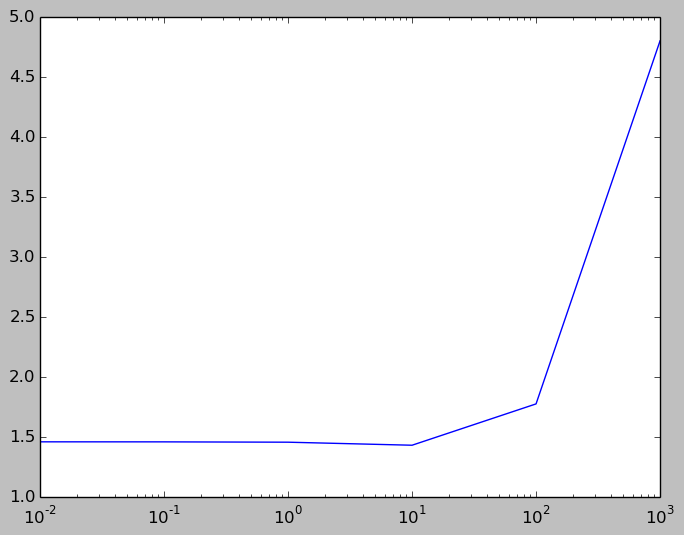

In [77]:
params = [0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
metrics = [evaluate(train_data, test_data, 10, 0.1, param, 'l1', False) for param in params]
print params
print metrics
plot(params, metrics)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')

In [86]:
model_l1 = LinearRegressionWithSGD.train(train_data, 10, 0.1,regParam=1.0, regType='l1', intercept=False)
model_l2 = LinearRegressionWithSGD.train(train_data, 10, 0.1,regParam=1.0, regType='l2', intercept=False)
model_l1_10 = LinearRegressionWithSGD.train(train_data, 10, 0.1,regParam=10.0, regType='l1', intercept=False)
model_l2_10 = LinearRegressionWithSGD.train(train_data, 10, 0.1,regParam=10.0, regType='l2', intercept=False)
model_l1_100 = LinearRegressionWithSGD.train(train_data, 10, 0.1,regParam=100.0, regType='l1', intercept=False)
model_l2_100 = LinearRegressionWithSGD.train(train_data, 10, 0.1,regParam=100.0, regType='l2', intercept=False)
print "L1 (1.0) number of zero weights: " + str(sum(model_l1.weights.array == 0))
print "L2 (1.0) number of zero weights: " + str(sum(model_l2.weights.array == 0))
print "L1 (10.0) number of zeros weights: " + str(sum(model_l1_10.weights.array == 0))
print "L2 (10.0) number of zeros weights: " + str(sum(model_l2_10.weights.array == 0))
print "L1 (100.0) number of zeros weights: " +str(sum(model_l1_100.weights.array == 0))
print "L2 (100.0) number of zeros weights: " +str(sum(model_l2_100.weights.array == 0))

L1 (1.0) number of zero weights: 5
L2 (1.0) number of zero weights: 4
L1 (10.0) number of zeros weights: 33
L2 (10.0) number of zeros weights: 4
L1 (100.0) number of zeros weights: 58
L2 (100.0) number of zeros weights: 4


[False, True]
[1.4064367998474196, 1.4358305401660159]


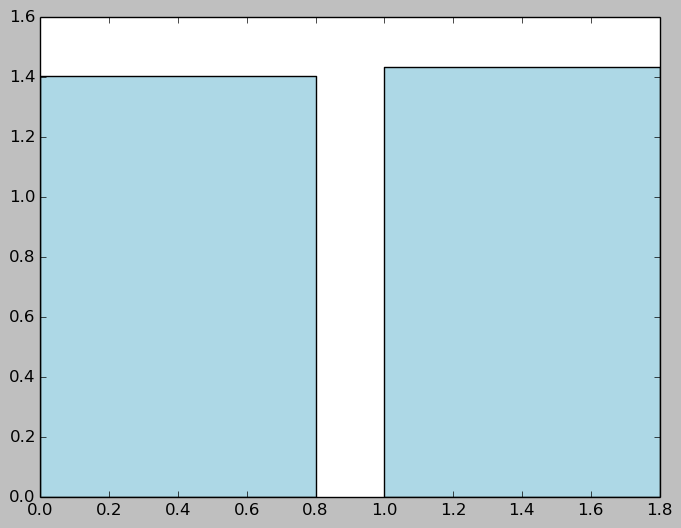

In [79]:
params = [False, True]
metrics = [evaluate(train_data, test_data, 10, 0.1, 1.0, 'l2', param) for param in params]
print params
print metrics
bar(params, metrics, color='lightblue')
fig = matplotlib.pyplot.gcf()

In [87]:
def evaluate_dt(train, test, maxDepth, maxBins):
    model = DecisionTree.trainRegressor(train, {},impurity='variance', maxDepth=maxDepth, maxBins=maxBins)
    preds = model.predict(test.map(lambda p: p.features))
    actual = test.map(lambda p: p.label)
    tp = actual.zip(preds)
    rmsle = np.sqrt(tp.map(lambda (t, p): squared_log_error(t,p)).mean())
    return rmsle

the rmsle: 1.009668 when maxDepth :1
the rmsle: 0.919700 when maxDepth :2
the rmsle: 0.815384 when maxDepth :3
the rmsle: 0.736622 when maxDepth :4
the rmsle: 0.637440 when maxDepth :5
the rmsle: 0.412534 when maxDepth :10
the rmsle: 0.442855 when maxDepth :20


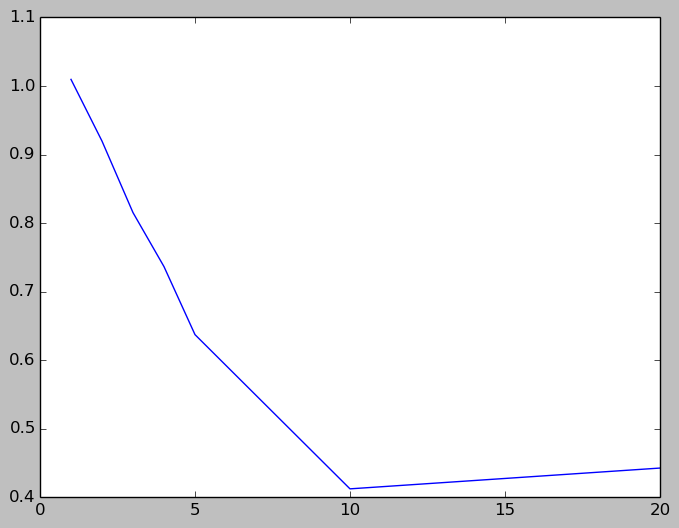

In [90]:
params = [1, 2, 3, 4, 5, 10, 20]
metrics = [evaluate_dt(train_data_dt, test_data_dt, param, 32) for
param in params]
for i in range(len(params)):
    print 'the rmsle: %f when maxDepth :%d'%(metrics[i],params[i])
plt.plot(params, metrics)
fig = matplotlib.pyplot.gcf()

the rmsle: 1.257196 when maxBins :2
the rmsle: 0.811638 when maxBins :4
the rmsle: 0.758462 when maxBins :8
the rmsle: 0.617405 when maxBins :16
the rmsle: 0.637440 when maxBins :32
the rmsle: 0.637440 when maxBins :64
the rmsle: 0.637440 when maxBins :100


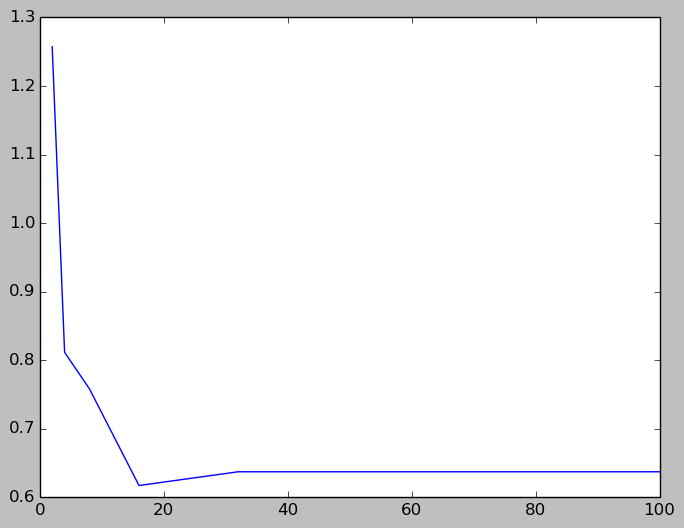

In [91]:
params = [2, 4, 8, 16, 32, 64, 100]
metrics = [evaluate_dt(train_data_dt, test_data_dt, 5, param) for
param in params]
for i in range(len(params)):
    print 'the rmsle: %f when maxBins :%d'%(metrics[i],params[i])
plt.plot(params, metrics)
fig = matplotlib.pyplot.gcf()

In [ ]:
t